In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import shapes
import pandas as pd
from shapely.geometry import shape

In [2]:
ndvi_mask = 'ndvi-open-spaces.tif'
kmeans_mask = 'kmeans-open-spaces.tif'
segment_anything_mask = 'segment-anything.tif'

In [3]:
def geotiff_to_gdf(filepath):
    with rasterio.open(filepath) as src:
        mask = src.read(1).astype('uint8')
        mask_transform = src.transform
        geometries = list(shapes(mask, transform=mask_transform))
        shapes_list = [{'properties': {'raster_val': v}, 'geometry': shape(geom)}
                        for geom, v in geometries if v == 0]
        gdf = gpd.GeoDataFrame.from_features(shapes_list)
        gdf.crs = src.crs
    return gdf

def gdf_to_shp(gdf, out_path):
    gdf.to_file(out_path)

def calculate_area(gdf):
    gdf['area_feet'] = gdf.area
    gdf['area_acres'] = gdf['area_feet'] / 43560
    return gdf['area_acres']

In [4]:
files = [ndvi_mask, kmeans_mask, segment_anything_mask]
results = []

for file in files:
    filename = file
    gdf = geotiff_to_gdf(file)    
    gdf['area_acres'] = calculate_area(gdf)
    results.append(gdf)

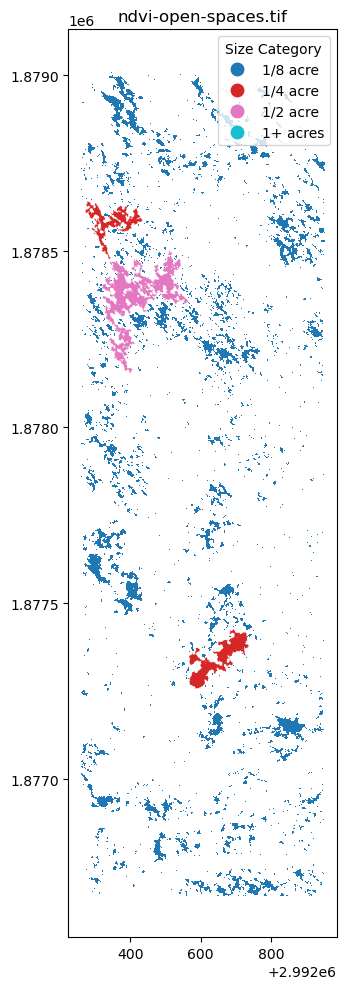

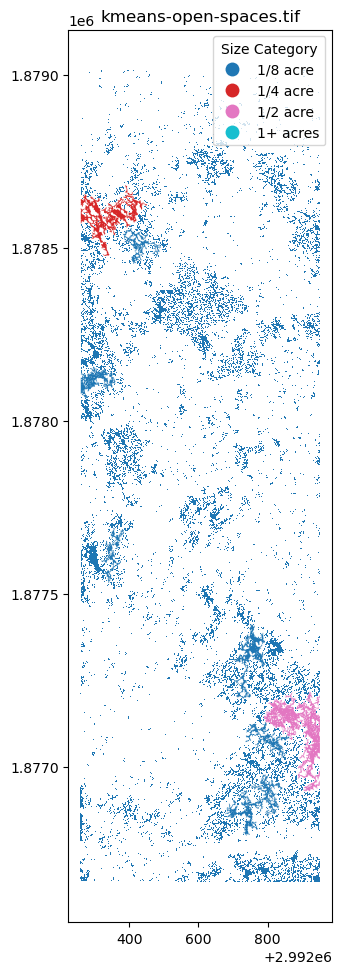

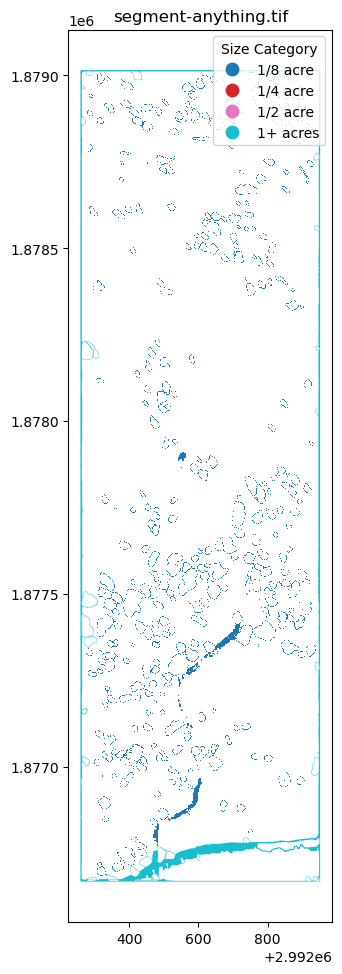

In [5]:
def bin_plot(gdf, bins, labels, title):
    gdf['size_category'] = pd.cut(gdf['area_acres'], bins=bins, labels=labels, right=False)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot = gdf.plot(column='size_category', ax=ax, legend=True, categorical=True, legend_kwds={'title': 'Size Category'})
    ax.set_title(title)
    plt.tight_layout()
    filename = title.split('.')[0]
    plt.savefig(f'{filename}.png')
    plt.show()

for i, result in enumerate(results):
    bins = [0, 1/8, 1/4, 1/2, 1]
    labels = ['1/8 acre', '1/4 acre', '1/2 acre', '1+ acres']
    title = files[i]
    bin_plot(result, bins, labels, title)